In [1]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions
using Test

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1342
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broke

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

In [489]:
using Plots

# grid for evaluation
xgrid = range(-4,4,length=201)
ygrid = copy(xgrid)
zgrid = xgrid .+ im*ygrid';

# unit circle
θ = range(0,2π,length=21)
sensors = exp.(im*θ[1:end-1]);

In [490]:
function routine_plot(state, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = cylinder_state_to_lagrange(state, config)
    Z = X .+ im*Y'
    ψ = imag.(LowRankVortex.F(Z, source))
    cylinder = 
    plt = plot(collect(X), collect(Y), ψ', ratio = 1.0, colorbar = false, 
                      xlim = (X[1], X[end]), 
                      ylim = (Y[1], Y[end]); levels = 10)
    plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
    if withvortices == true
        plot!(plt, source, markersize = 6, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

routine_plot (generic function with 1 method)

In [491]:
config_data = let Nv = 10, U = complex(0.0), 
             ss = sensors, Δt = 1e-3, δ = 1e-7,
             ϵX = 1e-4, ϵΓ = 1e-4,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

VortexConfig(10, 0.0 + 0.0im, ComplexF64[1.0 + 0.0im, 0.9510565162951535 + 0.3090169943749474im, 0.8090169943749475 + 0.5877852522924731im, 0.5877852522924731 + 0.8090169943749475im, 0.30901699437494745 + 0.9510565162951535im, 6.123233995736766e-17 + 1.0im, -0.30901699437494734 + 0.9510565162951536im, -0.587785252292473 + 0.8090169943749475im, -0.8090169943749473 + 0.5877852522924732im, -0.9510565162951535 + 0.3090169943749475im, -1.0 + 1.2246467991473532e-16im, -0.9510565162951536 - 0.3090169943749473im, -0.8090169943749475 - 0.587785252292473im, -0.5877852522924732 - 0.8090169943749473im, -0.30901699437494756 - 0.9510565162951535im, -1.8369701987210297e-16 - 1.0im, 0.30901699437494723 - 0.9510565162951536im, 0.5877852522924729 - 0.8090169943749476im, 0.8090169943749473 - 0.5877852522924734im, 0.9510565162951535 - 0.3090169943749476im], 0.001, 1.0e-7, 0.0001, 0.0001, 1.0, 0.01)

In [492]:
## Validation with one vortex of strength 1

zJ = 1.1*exp(im*0.0)
ΓJ = 2*π
blobs = map(Vortex.Point, [zJ], [ΓJ])

conjwJ = conj(ΓJ/(2*π*im)*(-1/(zJ -1/conj(zJ)) + 1/zJ))

conj(LowRankVortex.w(blobs[1].z, blobs; ϵ = config_data.δ))

0.0 - 4.329004329004325im

In [493]:
conj((-ΓJ)/(2*π*im)*inv(zJ*(abs2(zJ)-1)))

0.0 - 4.3290043290043245im

In [494]:
conjwJ

0.0 - 4.329004329004325im

In [516]:
blobs = create_random_vortices(config_data.Nv; σ=config_data.δ)

10-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(1.2508204690885458 + 1.47985258350075im, 1.4391544950805746, 1.0e-7)
 Vortex.Blob(0.5906861059703505 - 0.892748792606012im, 1.1919013504535156, 1.0e-7)
 Vortex.Blob(1.8585021874082575 + 1.9306536963311505im, 1.8000194628949036, 1.0e-7)
 Vortex.Blob(1.469552901112622 + 1.0614935786236943im, 1.3370020159424305, 1.0e-7)
 Vortex.Blob(0.5343800894654978 + 1.3056025716518027im, 1.164531351749702, 1.0e-7)
 Vortex.Blob(-1.9290605120620494 + 0.8174910239293194im, 1.091628837990946, 1.0e-7)
 Vortex.Blob(1.967675045728809 + 0.18469555660723103im, 1.0545572294618961, 1.0e-7)
 Vortex.Blob(-0.9479735080198886 - 0.942450738136932im, 2.6558194737677683, 1.0e-7)
 Vortex.Blob(1.1380935204710587 + 0.9897760295881515im, 2.073743229629872, 1.0e-7)
 Vortex.Blob(-0.8989296320110896 + 1.7622407975581433im, 1.5901331161588361, 1.0e-7)

In [517]:
Ne = 1
Ny = 10
Nx = 3*config_data.Nv

X0 = zeros(Ny+Nx, Ne)

X0[Ny+1:Ny+Nx,1] .= cylinder_lagrange_to_state(blobs, config_data)

X = deepcopy(X0);

In [518]:
X0

40×1 Matrix{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  1.2508204690885458
  1.47985258350075
  1.4391544950805746
  ⋮
  1.967675045728809
  0.18469555660723103
  1.0545572294618961
 -0.9479735080198886
 -0.942450738136932
  2.6558194737677683
  1.1380935204710587
  0.9897760295881515
  2.073743229629872
 -0.8989296320110896
  1.7622407975581433
  1.5901331161588361

In [519]:
cachevels = allocate_velocity(blobs)
Xf = Array{Float64,2}[]
push!(Xf, copy(state(X0, Ny, Nx)))

for i=1:5000
    X, _ = cylinder_vortex(X, 0.0, Ny, Nx, cachevels, config_data)
    push!(Xf, deepcopy(state(X, Ny, Nx)))
end

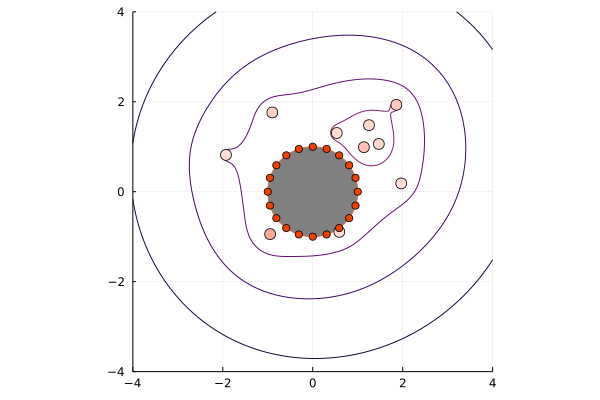

In [520]:
routine_plot(mean(Xf[1]; dims = 2)[:,1], config_data, xgrid, ygrid)

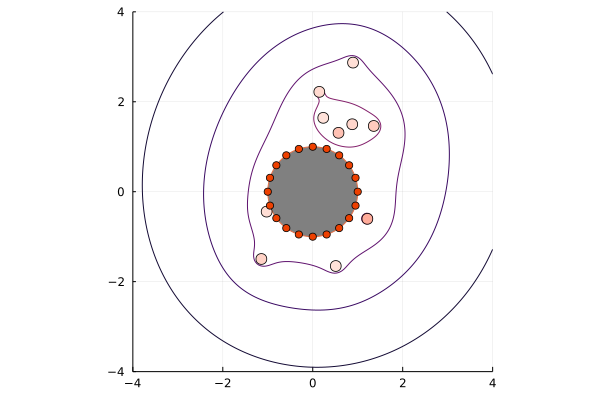

In [521]:
routine_plot(mean(Xf[end]; dims = 2)[:,1], config_data, xgrid, ygrid)

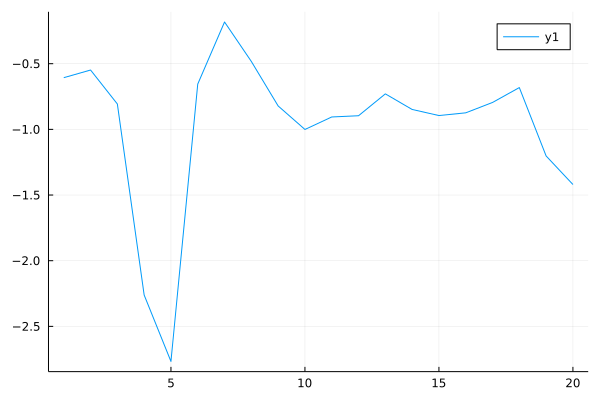

In [522]:
plot(pressure(config_data.ss, cylinder_state_to_lagrange(Xf[end][:,1], config_data)))

In [523]:
J = zeros(length(config_data.ss), Nx)

@time for i=1:config_data.Nv
    dpdzi = dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[1][:,1], config_data))
    J[:,3*i-2] .= 2*real(dpdzi)  
    J[:,3*i-1] .= -2*imag(dpdzi)
    
    dpdΓi = dpdΓv(config_data.ss, i, cylinder_state_to_lagrange(Xf[1][:,1], config_data))
    J[:,3*i] .= dpdΓi
end

  0.003211 seconds (332 allocations: 41.219 KiB)


In [524]:
U, Λ, V = svd(J);

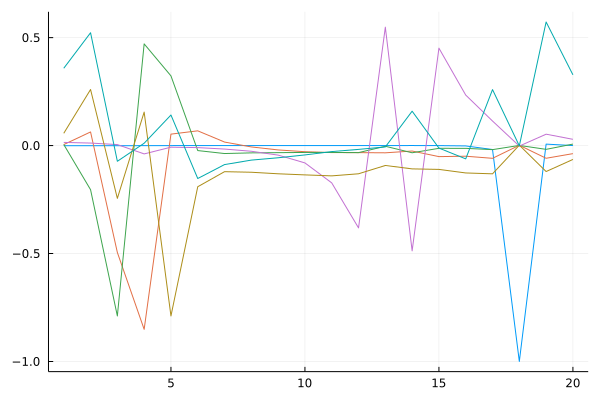

In [525]:
plt = plot(legend = false)

for i=1:6
    plot!(plt, U[:,i])
end
plt

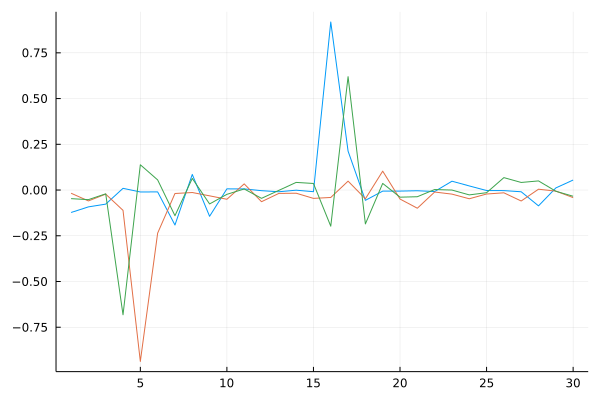

In [470]:
plt = plot(legend = false)

for i=1:3
    plot!(plt, V[:,i])
end
plt

In [471]:
(cumsum(Λ.^2)./sum(Λ.^2))[17]

0.9996953580398669

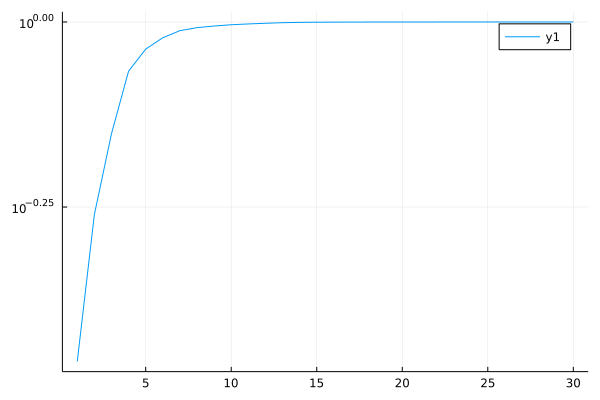

In [472]:
plot(cumsum(Λ.^2)./sum(Λ.^2), yscale = :log10)

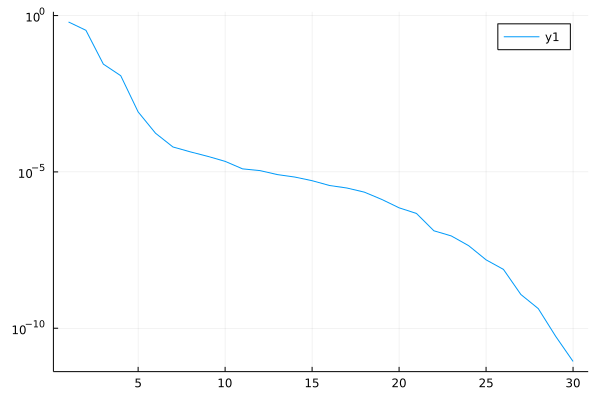

In [456]:
plot((Λ.^2)./sum(Λ.^2), yscale = :log10)

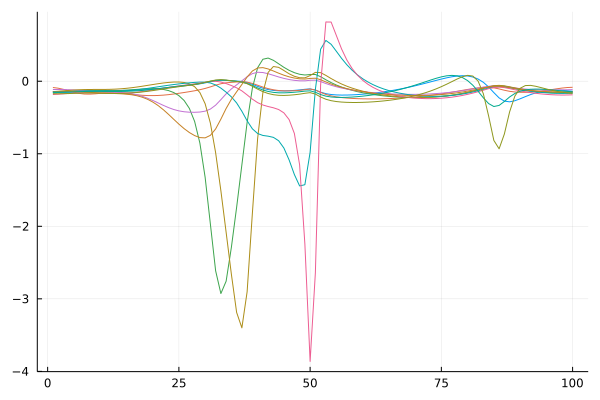

In [368]:
plt = plot(legend = false)

for i=1:config_data.Nv
#     plot!(plt, real(dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))))
#     plot!(plt, imag(dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))))
    plot!(plt, dpdΓv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data)))
end
plt

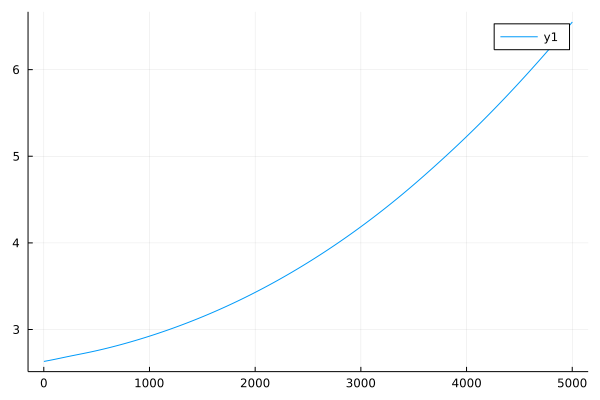

In [321]:
plot(map(xi -> xi[1]^2 + xi[2]^2, Xf))

In [370]:
-ΓJ/(4*π^2*(abs2(zJ)*(abs2(zJ)-1)))

-0.626347670570229

In [ ]:
10-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(1.5524030608054593 + 1.4966356498690878im, 1.777087057229044, 1.0e-7)
 Vortex.Blob(0.30297956811366955 - 1.5310233453394266im, 2.9950386389152985, 1.0e-7)
 Vortex.Blob(1.9533834668703678 + 1.5266552994597413im, 1.2339447083625958, 1.0e-7)
 Vortex.Blob(-1.0513133042403213 - 1.8227794557170132im, 1.6223707566499805, 1.0e-7)
 Vortex.Blob(-1.0836095985941654 + 0.7843079480127662im, 1.2450142628958365, 1.0e-7)
 Vortex.Blob(1.3467972420595151 + 0.7119955880276292im, 2.3945872015751033, 1.0e-7)
 Vortex.Blob(-1.543405087720262 - 0.948819867733115im, 2.391208846205823, 1.0e-7)
 Vortex.Blob(1.7504807284205954 - 1.4213977275321987im, 1.3496791100069796, 1.0e-7)
 Vortex.Blob(-1.2616569955408155 + 0.3668878315302502im, 1.7170363502434927, 1.0e-7)
 Vortex.Blob(0.9089535560506601 - 1.9950164010242206im, 1.6791417364879595, 1.0e-7)